### Import packages

In [1]:
import sys
sys.path.append("../")
from PREDICT import PREDICT
from PREDICT.Models import *
from PREDICT.Metrics import *
from PREDICT.Triggers import *
from PREDICT.Plots import *
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime
import statistics
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from lifelines import KaplanMeierFitter

import warnings
warnings.filterwarnings('ignore')

## Comparing Methods to Detect Temporal Drift

In this notebook, four methods to detect temporal drift are compared:

1) Regular model testing
2) Statistical process control
3) Static threshold
4) Bayesian variable relative change


<img src="..\docs\images\detect_methods.png" alt="Methods used to detect temporal drift" width="400">


These methods are compared for four scenarios:

1) Fast predictor change - COVID pandemic
2) Slow predictor change - population-based diabetes increase
3) Outcome drift - change in prevalence of diabetes mellitus
4) Multivariate drift - the diabetes prevalence increases whilst smoking prevalence decreases


In [16]:
startDateStrings = ['01-10-2024']#, '01-04-2020']#, '01-05-2020'] # TODO: make this longer

def get_model_updated_log(df, model, switch_times, i, model_name, undetected):
    mytest = PREDICT(data=df, model=model, startDate='min', endDate='max', timestep='month')
    mytest.run()
    log = mytest.getLog()
    if 'Model Updated' in log:
        # # get the first `model updated` time TODO this might need checking to ensure it's not just always taking the first Model Updated
        # first_update_time = next(iter(log['Model Updated']))
        # time_diff = first_update_time - switch_times[i] # TODO: might need to change this for non-covid models as it's start time instead of switch time
        dates = [date for date in log['Model Updated']]
        switch_time = pd.to_datetime(switch_times[i], dayfirst=True)
        model_update_date = next((date for date in dates if date > switch_time), None)
        if model_update_date:
            time_diff = model_update_date - switch_time
            ttd = abs(time_diff.days)
            
        else:
            ttd = None
            # add the model name to the undetected dictionary and add to the count
            count_for_model = undetected.get(model_name, 0)
            count_for_model += 1
            undetected[model_name] = count_for_model
        del mytest
        return ttd
    else:
        # if no model update, return None
        ttd = None
        del mytest
        # add the model name to the undetected dictionary and add to the count
        count_for_model = undetected.get(model_name, 0)
        count_for_model += 1
        undetected[model_name] = count_for_model
        return ttd
    

def get_binom_from_normal(mean, std, num_patients, threshold):
    """Get a binomial distribution for an outcome being over a certain threshold,
    using the mean and std of a normal distribution.

    Args:
        mean (float): Average value of the normal distribution.
        std (float): Standard deviation of the normal distribution.
        num_patients (int): Number of patients to simulate.
        threshold (float): Value which determines whether outcome or positive.

    Returns:
        np.array: Binomial distribution of outcomes.
    """
    # Generate normal distribution
    normal_dist = np.random.normal(mean, std, num_patients)
    
    # Calculate the percentage of patients above the threshold
    perc_over_threshold = np.sum(normal_dist >= threshold) / num_patients
    
    # Generate binomial distribution based on the percentage
    binom_dist = np.random.binomial(1, perc_over_threshold, num_patients)
    
    return binom_dist

import numpy as np

def select_ethnic_group(num_patients):
    # Define ethnicity groups
    ethnic_groups = ["White", "Indian", "Pakistani", "Bangladeshi", "Other_Asian",
                    "Black_Caribbean", "Black_African", "Chinese", "Other"]

    # Define probabilities for selection (must sum to 1)
    probabilities = [0.973, 0.0046, 0.0025, 0.0025, 0.0015, 0.0050, 0.0047, 0.0015, 0.0047]

    # Initialize dictionary with empty lists
    ethnicity_assignments = {eth: [] for eth in ethnic_groups}

    # Repeat selection num_patients times
    for _ in range(num_patients):
        selected_ethnicity = np.random.choice(ethnic_groups, p=probabilities)

        # Assign selected ethnicity as "1", others as "0"
        for eth in ethnic_groups:
            ethnicity_assignments[eth].append(1 if eth == selected_ethnicity else 0)
    
    ethnicity_assignments = {eth: np.array(vals) for eth, vals in ethnicity_assignments.items()}

    return ethnicity_assignments

#### Interactive plot to show the variables: `switch time`, `drop size` and `time to detection/gap`

In [8]:
def plot_data(switch_time, drop_perc, gap):
    time = np.linspace(0, 10, 100)
    predictor = np.ones_like(time) * 10  # Initial horizontal line

    drop_size = predictor.max() * drop_perc / 100  # Calculate the drop size based on percentage
    
    # Apply the drop effect over the period from switch_time to switch_time + gap
    drop_start = switch_time
    drop_end = switch_time + gap
    
    # Gradual drop over the duration of gap
    drop_mask = (time >= drop_start) & (time <= drop_end)
    predictor[drop_mask] -= (drop_size / gap) * (time[drop_mask] - drop_start)
    
    predictor[time > drop_end] -= drop_size  # Maintain the lower level after drop completion

    plt.figure(figsize=(8, 5))
    plt.annotate('', xy=(drop_start, min(predictor)), xytext=(drop_end, min(predictor)), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f"Time to detect: {gap:.1f} years", xy=(drop_start + gap / 2, predictor.min()-0.5), fontsize=8, ha='center', color='red')

    plt.annotate('', xy=(0, max(predictor)+0.3), xytext=(switch_time, max(predictor)+0.3), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f"Switch time: {switch_time:.1f} years", xy=(switch_time / 2, predictor.max()+0.5), fontsize=8, ha='center')

    plt.annotate('', xy=(switch_time+gap, min(predictor)), xytext=(switch_time+gap, max(predictor)), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f"Drop size: {drop_size:.1f}", xy=(switch_time+gap+1, (predictor.max()+predictor.min())/2), fontsize=8, ha='center')
    
    plt.plot(time, predictor, label="Predictor")
    plt.axvline(switch_time, color='r', linestyle='--', label="Switch Time (t)")
    plt.axvline(switch_time+gap, color='green', linestyle='--', label="Time when Model Detected Change")
    plt.xlabel("Time (TE) [1, 10 years]")
    plt.ylabel("Predictor (k)")
    plt.ylim(0, 15)  # Set y-axis limits for better visibility
    plt.legend()
    plt.grid()
    plt.show()

# Sliders to control parameters
interact(plot_data,
        switch_time=FloatSlider(min=0, max=10, step=1, value=2, description="Switch Time (t)"),
        drop_perc=FloatSlider(min=-40, max=90, step=10, value=15, description="Drop Size (%)"),
        gap=FloatSlider(min=0.1, max=5, step=0.1, value=1, description="Gap (g)"))

interactive(children=(FloatSlider(value=2.0, description='Switch Time (t)', max=10.0, step=1.0), FloatSlider(v…

<function __main__.plot_data(switch_time, drop_perc, gap)>

In [9]:
def drop_size_toy(custom_impact):
    mydict = {
        'date': list(),
        'outcome': list(),
        'prediction': list(),
        'age': list(),
        'systolic_bp': list()
    }

    np.random.seed(42)
    num_patients = 20

    # Define date range and COVID shock periods
    startDate = pd.to_datetime('01-06-2019', dayfirst=True)  # Start a year before COVID
    endDate = pd.to_datetime('31-12-2021', dayfirst=True)  # Include recovery period after COVID
    switchDate = pd.to_datetime('01-03-2020', dayfirst=True)  # COVID starts spreading
    switchDate2 = pd.to_datetime('01-06-2020', dayfirst=True)  # Peak of the pandemic
    recoveryDate = pd.to_datetime('01-06-2021', dayfirst=True)  # Start of recovery phase
    numdays = (endDate - startDate).days
    switchDays = (switchDate - startDate).days
    switch2Days = (switchDate2 - startDate).days
    recoveryDays = (recoveryDate - startDate).days

    for i in range(numdays):
        curday = startDate + dt.timedelta(days=i)

        age = np.random.normal(70, 5, num_patients)  # Mean age 70 years, std 5
        systolic_bp = np.random.normal(120, 20, num_patients)  # Mean systolic blood pressure 120 mmHg, std 20

        # Calculate baseline log-odds
        lp = -1.5 + 0.5 * (age - 70) / 5 + 2 * (systolic_bp - 120) / 20
        curpredictions = 1 / (1 + np.exp(-lp))  # Convert to probability

        # Simulate COVID effects
        if switchDays <= i < switch2Days:
            #lp += 1.5  # Initial impact of COVID
            lp += custom_impact  # Initial impact of COVID
        elif switch2Days <= i < recoveryDays:
            #lp += 2.0  # Peak of the pandemic
            lp += custom_impact + 0.5  # Peak of the pandemic
        elif i >= recoveryDays:
            lp -= 1.0  # Recovery period—improved health outcomes


        # Generate outcomes
        curoutcomes = np.random.binomial(1, 1 / (1 + np.exp(-lp)))  # Simulate "COVID" events

        # Append to dictionary
        mydict['date'].extend([curday] * num_patients)
        mydict['outcome'].extend(curoutcomes)
        mydict['prediction'].extend(curpredictions)
        mydict['age'].extend(age)
        mydict['systolic_bp'].extend(systolic_bp)

    df = pd.DataFrame(mydict)


    eval_model = EvaluatePredictions(colName='prediction')
    mytest = PREDICT(data=df, model=eval_model, startDate='min', endDate='max', timestep='week')
    mytest.addLogHook(CalibrationSlope(eval_model))
    mytest.run()
    log = mytest.getLog()
    CalibrationSlopePlot(log)


    calibration_slope_values = list(log['CalibrationSlope'].values())
    # get the difference between the mean of the calibration slope values and the greatest deviation from 0 calibration slope value for the drop size
    largest_c_slope_change = max(abs(min(calibration_slope_values)), abs(max(calibration_slope_values)))
    drop_size = abs(statistics.mean(calibration_slope_values) - largest_c_slope_change)

    print("Drop size (change in calibration from mean):", drop_size)

interact(drop_size_toy,
        custom_impact=FloatSlider(min=0.5, max=6, step=0.5, value=2, description="initial covid impact"))

interactive(children=(FloatSlider(value=2.0, description='initial covid impact', max=6.0, min=0.5, step=0.5), …

<function __main__.drop_size_toy(custom_impact)>

#### Distributions used for the COVID/shock change data are from: [Prediction for Progression Risk in Patients With COVID-19 Pneumonia: The CALL Score](https://academic.oup.com/cid/article/71/6/1393/5818317).
Hazards ratios were reported in this paper that we convert to log-odds using log(HR).


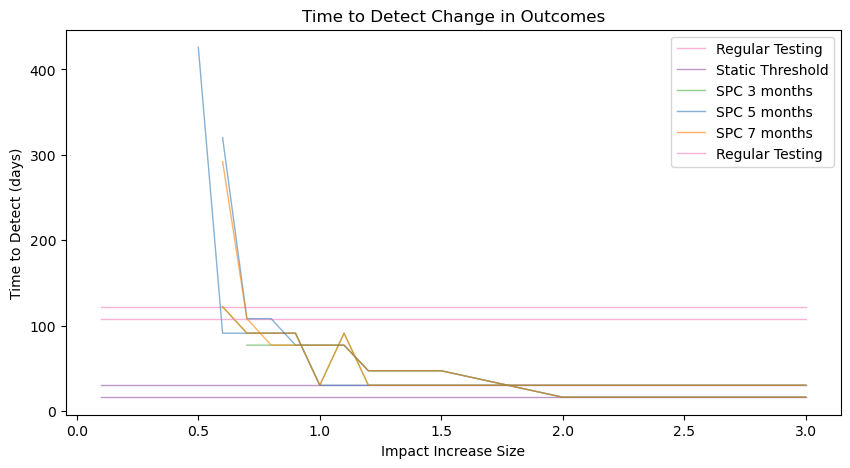

Total number of times each model was ran: 36
Number of times each model didn't detect change in outcomes: {'Static Threshold': 0, 'Regular Testing': 0, 'SPC3': 11, 'SPC5': 9, 'SPC7': 10, 'Bayesian': 0}
Percentage of times each model didn't detect change in outcomes: {'Static Threshold': 0.0, 'Regular Testing': 0.0, 'SPC3': 30.555555555555557, 'SPC5': 25.0, 'SPC7': 27.77777777777778, 'Bayesian': 0.0}


In [20]:
total_runs = 0

#custom_impacts = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
custom_impacts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 2.0, 2.5, 3.0]
switchDateStrings = ['01-04-2020', '15-04-2020']#, '01-05-2020']
undetected = dict({"Static Threshold": 0, "Regular Testing": 0, "SPC3": 0, "SPC5":0, "SPC7":0, "Bayesian": 0})

hr_age = 0.5
hr_ldh = 9.8
hr_comorbidity = 3.9

log_age = np.log(hr_age)
log_ldh = np.log(hr_ldh)
log_comorbidity = np.log(hr_comorbidity)

plt.figure(figsize=(10, 5))
plt.title(f"Time to Detect Change in Outcomes")

for switchDateidx, switchDateString in enumerate(switchDateStrings):
    drop_sizes = []
    regular_ttd = []
    static_ttd = []
    spc_ttd3 = []
    spc_ttd5 = []
    spc_ttd7 = []
    bayesian_ttd = []
    for custom_impact in custom_impacts:
        mydict = {
                'date': list(),
                'outcome': list(),
                'prediction': list(),
                'age': list(),
                'sex': list(),
                'comorbidity': list(),
                'ldh_high': list()
            }

        num_patients = 40

        # Define date range and COVID shock periods
        startDate = pd.to_datetime('01-06-2019', dayfirst=True)  # Start a year before COVID
        endDate = pd.to_datetime('31-12-2021', dayfirst=True)  # Include recovery period after COVID
        switchDate = pd.to_datetime(switchDateString, dayfirst=True)  # COVID starts spreading
        switchDate2 = pd.to_datetime('01-06-2020', dayfirst=True)  # Peak of the pandemic
        recoveryDate = pd.to_datetime('01-06-2021', dayfirst=True)  # Start of recovery phase
        numdays = (endDate - startDate).days
        switchDays = (switchDate - startDate).days
        switch2Days = (switchDate2 - startDate).days
        recoveryDays = (recoveryDate - startDate).days

        for i in range(numdays):
            curday = startDate + dt.timedelta(days=i)

            age = np.random.normal(44, 16.3, num_patients)  # Mean age 44 years, std 16.3
            sex = np.random.binomial(1, 0.562, num_patients) # 56.2% are male
            comorbidity = np.random.binomial(1, 0.3, num_patients)  # 30% have comorbidities
            ldh_high = np.random.binomial(1, 0.15, num_patients)  # 15% have LDH >500 U/L


            # Calculate baseline log-odds
            # sex influence 1.2 due to not being provided in the paper
            lp = -1.5 + log_age * (age - 44) / 16.3 +  log_ldh * (ldh_high - 0.15) + log_comorbidity * (comorbidity - 0.3) + 1.2 * (sex - 0.562)
            curpredictions = 1 / (1 + np.exp(-lp))  # Convert to probability

            # Simulate COVID effects
            if switchDays <= i < switch2Days:
                #lp += 1.5  # Initial impact of COVID
                lp += custom_impact  # Initial impact of COVID
            elif switch2Days <= i < recoveryDays:
                #lp += 2.0  # Peak of the pandemic
                lp += custom_impact + 0.5  # Peak of the pandemic
            elif i >= recoveryDays:
                lp -= 1.0  # Recovery period—improved health outcomes


            # Generate outcomes
            curoutcomes = np.random.binomial(1, 1 / (1 + np.exp(-lp)))  # Simulate COVID events

            # Append to dictionary
            mydict['date'].extend([curday] * num_patients)
            mydict['outcome'].extend(curoutcomes)
            mydict['prediction'].extend(curpredictions)
            mydict['age'].extend(age)
            mydict['sex'].extend(sex)
            mydict['comorbidity'].extend(comorbidity)
            mydict['ldh_high'].extend(ldh_high)

        df = pd.DataFrame(mydict)

        # # run EvaluatePrediction code to get the model metrics and when calibration drops
        # eval_model = EvaluatePredictions(colName='prediction')
        # mytest = PREDICT(data=df, model=eval_model, startDate='min', endDate='max', timestep='week')
        # mytest.addLogHook(CalibrationSlope(eval_model))
        # mytest.run()
        # log = mytest.getLog()
        # #CalibrationSlopePlot(log)


        # calibration_slope_values = list(log['CalibrationSlope'].values())
        # # get the difference between the mean of the calibration slope values and the greatest deviation from 0 calibration slope value for the drop size
        # largest_c_slope_change = max(abs(min(calibration_slope_values)), abs(max(calibration_slope_values)))
        # drop_size = abs(statistics.mean(calibration_slope_values) - largest_c_slope_change)
        #drop_sizes.append(drop_size)

        drop_sizes.append(custom_impact)
        # run regular testing
        ########################## Regular Testing ##########################
        model = RecalibratePredictions()
        model.trigger = TimeframeTrigger(model=model, updateTimestep=100, dataStart=df['date'].min(), dataEnd=df['date'].max())
        total_runs +=1
        ttd = get_model_updated_log(df, model, switchDateStrings, switchDateidx, "Regular Testing", undetected)
        regular_ttd.append(ttd)

        ############################ Static Threshold ############################
        model = RecalibratePredictions()
        recalthreshold = 0.86 # Paper has AUROC of 0.91, with lower CI at 0.86
        model.trigger = AUROCThreshold(model=model, prediction_threshold=recalthreshold) 
        ttd = get_model_updated_log(df, model, switchDateStrings, switchDateidx, "Static Threshold", undetected)
        static_ttd.append(ttd)

        ############################ SPC ############################
        model = RecalibratePredictions()
        model.trigger = SPCTrigger(model=model, input_data=df, numMonths=3, verbose=False)
        ttd = get_model_updated_log(df, model, switchDateStrings, switchDateidx, "SPC3", undetected)
        spc_ttd3.append(ttd)
        model.trigger = SPCTrigger(model=model, input_data=df, numMonths=5, verbose=False)
        ttd = get_model_updated_log(df, model, switchDateStrings, switchDateidx, "SPC5", undetected)
        spc_ttd5.append(ttd)
        model.trigger = SPCTrigger(model=model, input_data=df, numMonths=7, verbose=False)
        ttd = get_model_updated_log(df, model, switchDateStrings, switchDateidx, "SPC7", undetected)
        spc_ttd7.append(ttd)

        ############################ Bayesian ############################
        # model = BayesianModel(input_data=df, priors={"Intercept": (-1.5, 0.1), "age": (44, 16.3), "sex": (1, 0.562), "comorbidity": (1, 0.3), "ldh_high": (1, 0.15)}, cores=1, verbose=False, draws=100, chains=2)
        # model.trigger = BayesianRefitTrigger(model=model, input_data=df, refitFrequency=1)
        # ttd = get_model_updated_log(df, model, switchDateStrings, switchDateidx, "Bayesian", undetected)
        # bayesian_ttd.append(ttd)
            

    # plot the time to detect for all models
    regular_ttd_df = pd.DataFrame({"drop_sizes": drop_sizes, "regular_ttd": regular_ttd}).dropna(inplace=False)
    plt.plot("drop_sizes", "regular_ttd", color='#f781bf', label='Regular Testing', alpha=0.6, linewidth=1, data=regular_ttd_df)
    static_ttd_df = pd.DataFrame({"drop_sizes": drop_sizes, "static_ttd": static_ttd}).dropna(inplace=False)
    plt.plot("drop_sizes", "static_ttd", color='#984ea3', label='Static Threshold', alpha=0.6, linewidth=1, data=static_ttd_df)
    spc_ttd3_df = pd.DataFrame({"drop_sizes": drop_sizes, "spc_ttd3": spc_ttd3}).dropna(inplace=False)
    plt.plot("drop_sizes", "spc_ttd3", color='#4daf4a', label='SPC 3 months', alpha=0.6, linewidth=1, data=spc_ttd3_df)
    spc_ttd5_df = pd.DataFrame({"drop_sizes": drop_sizes, "spc_ttd5": spc_ttd5}).dropna(inplace=False)
    plt.plot("drop_sizes", "spc_ttd5", color='#377eb8', label='SPC 5 months', alpha=0.6, linewidth=1, data=spc_ttd5_df)
    spc_ttd7_df = pd.DataFrame({"drop_sizes": drop_sizes, "spc_ttd7": spc_ttd7}).dropna(inplace=False)
    plt.plot("drop_sizes", "spc_ttd7", color='#ff7f00', label='SPC 7 months', alpha=0.6, linewidth=1, data=spc_ttd7_df)
    # bayesian_ttd_df = pd.DataFrame({"drop_sizes": drop_sizes, "bayesian_ttd": bayesian_ttd}).dropna(inplace=False)
    # plt.plot("drop_sizes", "bayesian_ttd", color='#a65628', label='Bayesian', alpha=0.6, linewidth=1, data=bayesian_ttd_df)
plt.xlabel("Impact Increase Size")
plt.ylabel("Time to Detect (days)")
handles, labels = plt.gca().get_legend_handles_labels()
# Ensure only the first plot of each model is labelled in the legend
plt.legend(handles[:6], labels[:6])
plt.show()

# Print the number of undetected models
print(f"Total number of times each model was ran: {total_runs}")
percentages = {key: (value / total_runs * 100) if total_runs > 0 else 0 for key, value in undetected.items()}
print("Number of times each model didn't detect change in outcomes:", undetected)
print("Percentage of times each model didn't detect change in outcomes:", percentages)


#### Outcome prevalence data drift

- Logistic regression model to use coefficients from for outcome drift e.g. diabetes

Using logistic regression non-laboratory coefficients from [Prediction of Type 2 diabetes mellitus onset using logistic regression-based scorecards](https://elifesciences.org/articles/71862)



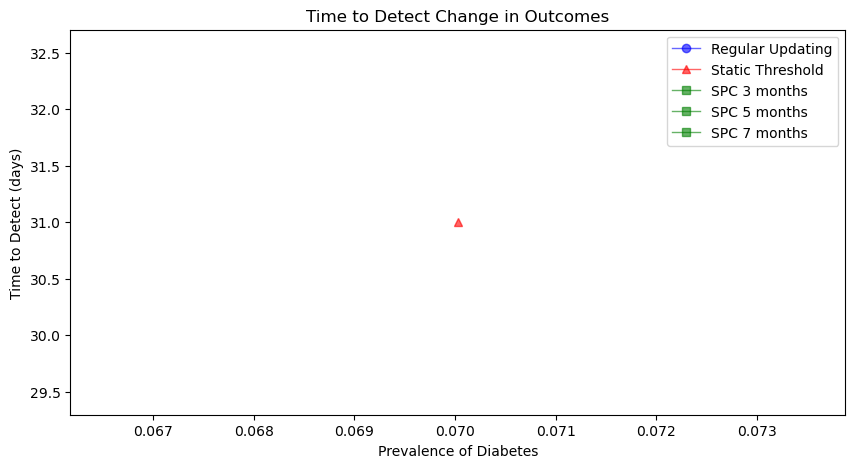

Total number of times each model was ran: 1
Number of times each model didn't detect change in outcomes: {'Static Threshold': 0, 'Regular Testing': 1, 'SPC3': 1, 'SPC5': 1, 'SPC7': 1, 'Bayesian': 0}
Percentage of times each model didn't detect change in outcomes: {'Static Threshold': 0.0, 'Regular Testing': 100.0, 'SPC3': 100.0, 'SPC5': 100.0, 'SPC7': 100.0, 'Bayesian': 0.0}


In [29]:
total_runs = 0

prev_increases = [1.0001]#, 1.0003, 1.0005, 1.0007, 1.0009, 1.0011, 1.0013, 1.0015, 1.0017, 1.0019, 1.0021, 1.0023, 1.0025, 1.0027, 1.0029]
undetected = dict({"Static Threshold": 0, "Regular Testing": 0, "SPC3": 0, "SPC5": 0, "SPC7": 0, "Bayesian": 0})

# coefficients from non-laboratory logistic regression model
age_at_lv_coef = 0.16 # lv = last visit
bmi_coef = 0.68
hip_circ_coef = -0.05
sex_coef = -0.14
height_coef = -0.15
waist_circ_coef = 0.31
waist_hips_ratio_coef = 0.54
weight_coef = 0.03
time_between_visits_coef = 0.38
bias_coef = -0.74

# mean and standard deviation for each predictor
# variable at the last visit is used

mean_age = 62.9
std_age = 7.5
mean_bmi = 26.6
std_bmi = 4.4
mean_hip_circ = 101.6
std_hip_circ = 8.8
perc_male = 0.478
mean_height = 169
std_height = 9.2
mean_waist_circ = 88.7
std_waist_circ = 12.7
mean_waist_hips_ratio = mean_waist_circ/mean_hip_circ
std_waist_hips_ratio = mean_waist_hips_ratio * np.sqrt(
    (std_waist_circ / mean_waist_circ) ** 2 +
    (std_hip_circ / mean_hip_circ) ** 2)
mean_weight = 76.2
std_weight = 15.2
mean_time_between_visits = 7.3
std_time_between_visits = 2.3

plt.figure(figsize=(10, 5))
plt.title(f"Time to Detect Change in Outcomes")

for startDateidx, startDateString in enumerate(startDateStrings):
    dm_prev = 0.07  # Initial diabetes prevalence = 7%
    dm_increases = []
    regular_ttd = []
    static_ttd = []
    spc_ttd3 = []
    spc_ttd5 = []
    spc_ttd7 = []
    bayesian_ttd = []
    for prev_increase in prev_increases:
        mydict = {
                'date': list(),
                'outcome': list(),
                'prediction': list(),
                'age': list(),
                'bmi':list(),
                'hip_circ': list(),
                'sex': list(),
                'height': list(),
                'waist_circ': list(),
                'waist_hips_ratio': list(),
                'weight': list(),
                'time_between_visits': list()
            }

        num_patients = 60

        # Define date range
        startDate = pd.to_datetime(startDateString, dayfirst=True)
        endDate = pd.to_datetime('31-12-2024', dayfirst=True)
        numdays = (endDate - startDate).days
        
        for i in range(numdays):
            curday = startDate + dt.timedelta(days=i)

            age = np.random.normal(mean_age, std_age, num_patients)
            bmi = np.random.normal(mean_bmi, std_bmi, num_patients)
            hip_circ = np.random.normal(mean_hip_circ, std_hip_circ, num_patients)
            sex = np.random.binomial(1, perc_male, num_patients)
            height = np.random.normal(mean_height, std_height, num_patients)
            waist_circ = np.random.normal(mean_waist_circ, std_waist_circ, num_patients)
            waist_hips_ratio = np.random.normal(mean_waist_hips_ratio, std_waist_hips_ratio, num_patients)
            weight = np.random.normal(mean_weight, std_weight, num_patients)
            time_between_visits = np.random.normal(mean_time_between_visits, std_time_between_visits, num_patients)

            # Calculate baseline log-odds
            lp = bias_coef + age_at_lv_coef * (age - mean_age)/std_age + bmi_coef * (bmi - mean_bmi)/std_bmi + hip_circ_coef * (hip_circ - mean_hip_circ)/std_hip_circ + sex_coef * (sex - perc_male) + height_coef * (height - mean_height)/std_height + waist_circ_coef * (waist_circ - mean_waist_circ)/std_waist_circ + waist_hips_ratio_coef * (waist_hips_ratio - mean_waist_hips_ratio)/std_waist_hips_ratio + weight_coef * (weight - mean_weight)/std_weight + time_between_visits_coef * (time_between_visits - mean_time_between_visits)/std_time_between_visits
            
            curpredictions = 1 / (1 + np.exp(-lp))  # Convert to probability


            # Generate outcomes to simulate diabetes rates increasing over time
            # In 1980 prevalence was 4.7% 2021 prevalence was 10%, so assume a linear increase of 0.125% each year and 0.01% each month
            if i % 30 == 0:
                dm_prev *= prev_increase # this increases the probability by x% each month

            curoutcomes = np.random.binomial(1, dm_prev*curpredictions)           
            

            # Append to dictionary from the distribution for each of the variables (Table 1)
            mydict['date'].extend([curday] * num_patients)
            mydict['outcome'].extend(curoutcomes)
            mydict['prediction'].extend(curpredictions)
            mydict['age'].extend(age)
            mydict['bmi'].extend(bmi)
            mydict['hip_circ'].extend(hip_circ)
            mydict['sex'].extend(sex)
            mydict['height'].extend(height)
            mydict['waist_circ'].extend(waist_circ)
            mydict['waist_hips_ratio'].extend(waist_hips_ratio)
            mydict['weight'].extend(weight)
            mydict['time_between_visits'].extend(time_between_visits)
            

        df = pd.DataFrame(mydict)

        # run EvaluatePrediction code to get the model metrics and when calibration drops (maybe switch time from this too)
        eval_model = EvaluatePredictions(colName='prediction')
        mytest = PREDICT(data=df, model=eval_model, startDate='min', endDate='max', timestep='week')
        mytest.addLogHook(CalibrationSlope(eval_model))
        mytest.run()
        log = mytest.getLog()
        #CalibrationSlopePlot(log)


        calibration_slope_values = list(log['CalibrationSlope'].values())
        # get the difference between the mean of the calibration slope values and the greatest deviation from 0 calibration slope value for the drop size
        largest_c_slope_change = max(abs(min(calibration_slope_values)), abs(max(calibration_slope_values)))
        drop_size = abs(statistics.mean(calibration_slope_values) - largest_c_slope_change)
        


        
        #drop_sizes.append(drop_size)
        dm_increases.append(dm_prev)
        # run regular testing
        ########################## Regular Testing ##########################
        model = RecalibratePredictions()
        model.trigger = TimeframeTrigger(model=model, updateTimestep=100, dataStart=df['date'].min(), dataEnd=df['date'].max())
        total_runs +=1
        ttd = get_model_updated_log(df, model, startDateStrings, startDateidx, "Regular Testing", undetected)
        regular_ttd.append(ttd)

        ############################ Static Threshold ############################
        model = RecalibratePredictions()
        recalthreshold = 0.77 # Paper has AUROC of 0.81, with lower CI at 0.77 
        model.trigger = AUROCThreshold(model=model, prediction_threshold=recalthreshold)
        ttd = get_model_updated_log(df, model, startDateStrings, startDateidx, "Static Threshold", undetected)
        static_ttd.append(ttd)

        ############################ SPC ############################
        model = RecalibratePredictions()
        model.trigger = SPCTrigger(model=model, input_data=df, numMonths=3, verbose=False)
        ttd = get_model_updated_log(df, model, startDateStrings, startDateidx, "SPC3", undetected)
        spc_ttd3.append(ttd)

        model.trigger = SPCTrigger(model=model, input_data=df, numMonths=5, verbose=False)
        ttd = get_model_updated_log(df, model, startDateStrings, startDateidx, "SPC5", undetected)
        spc_ttd5.append(ttd)

        model.trigger = SPCTrigger(model=model, input_data=df, numMonths=7, verbose=False)
        ttd = get_model_updated_log(df, model, startDateStrings, startDateidx, "SPC7", undetected)
        spc_ttd7.append(ttd)

        ############################ Bayesian ############################
        # model = BayesianModel(input_data=df, priors={"Intercept": (bias_coef, 0.1), "age": (mean_age, std_age), "bmi": (mean_bmi, std_bmi), "hip_circ": (mean_hip_circ, std_hip_circ),
        #                                             "sex": (sex_coef, 0.1), "height":(mean_height, std_height), "waist_circ":(mean_waist_circ, std_waist_circ),
        #                                             "waist_hips_ratio":(mean_waist_hips_ratio, std_waist_hips_ratio), "weight":(mean_weight, std_weight), 
        #                                             "time_between_visits":(mean_time_between_visits, std_time_between_visits)}, cores=1, verbose=False, draws=100, chains=2)
        # model.trigger = BayesianRefitTrigger(model=model, input_data=df, refitFrequency=1)
        # ttd = get_model_updated_log(df, model, startDateStrings, startDateidx, "Bayesian", undetected)
        # bayesian_ttd.append(ttd)




    # plot the time to detect for all models

    regular_ttd_df = pd.DataFrame({"dm_increases": dm_increases, "regular_ttd": regular_ttd}).dropna(inplace=False)
    plt.plot("dm_increases", "regular_ttd", color='blue', label='Regular Updating', marker='o', alpha=0.6, linewidth=1, data=regular_ttd_df)
    static_ttd_df = pd.DataFrame({"dm_increases": dm_increases, "static_ttd": static_ttd}).dropna(inplace=False)
    plt.plot("dm_increases", "static_ttd", color='red', label='Static Threshold', marker='^', alpha=0.6, linewidth=1, data=static_ttd_df)
    
    spc_ttd3_df = pd.DataFrame({"dm_increases": dm_increases, "spc_ttd3": spc_ttd3}).dropna(inplace=False)
    plt.plot("dm_increases", "spc_ttd3", color='green', label='SPC 3 months', marker='s', alpha=0.6, linewidth=1, data=spc_ttd3_df)
    spc_ttd5_df = pd.DataFrame({"dm_increases": dm_increases, "spc_ttd5": spc_ttd5}).dropna(inplace=False)
    plt.plot("dm_increases", "spc_ttd5", color='green', label='SPC 5 months', marker='s', alpha=0.6, linewidth=1, data=spc_ttd5_df)
    spc_ttd7_df = pd.DataFrame({"dm_increases": dm_increases, "spc_ttd7": spc_ttd7}).dropna(inplace=False)
    plt.plot("dm_increases", "spc_ttd7", color='green', label='SPC 7 months', marker='s', alpha=0.6, linewidth=1, data=spc_ttd7_df)
    # bayesian_ttd_df = pd.DataFrame({"dm_increases": dm_increases, "bayesian_ttd": bayesian_ttd}).dropna(inplace=False)
    # plt.plot("dm_increases", "bayesian_ttd", color='purple', label='Bayesian', marker='x', alpha=0.6, linewidth=1, data=bayesian_ttd_df)
plt.xlabel("Prevalence of Diabetes")
plt.ylabel("Time to Detect (days)")
handles, labels = plt.gca().get_legend_handles_labels()
# Ensure only the first plot of each model is labelled in the legend
plt.legend(handles[:6], labels[:6])
plt.show()


# Print the number of undetected models
print(f"Total number of times each model was ran: {total_runs}")
percentages = {key: (value / total_runs * 100) if total_runs > 0 else 0 for key, value in undetected.items()}
print("Number of times each model didn't detect change in outcomes:", undetected)
print("Percentage of times each model didn't detect change in outcomes:", percentages)


#### Slow change data simulation

Diabetes as a predictor (increasing over time) with CKD as the predicted outcome.

https://pmc.ncbi.nlm.nih.gov/articles/PMC8854510/

TGF-β normal high value (0: < 1.011 pg/mL; 1:1.011 pg/mL), 
ADMA normal high value (0: < 0.019 μmol/L; 1: ≥ 0.019 μmol/L), 
diabetes (0:unaffected; 1:affected), 
BUN (urea nitrogen) normal high value (0: < 5.9 mmol/L; 1: ≥ 5.9 mmol/L), 
elderly (0: < 60 years; 1: ≥ 60 years).

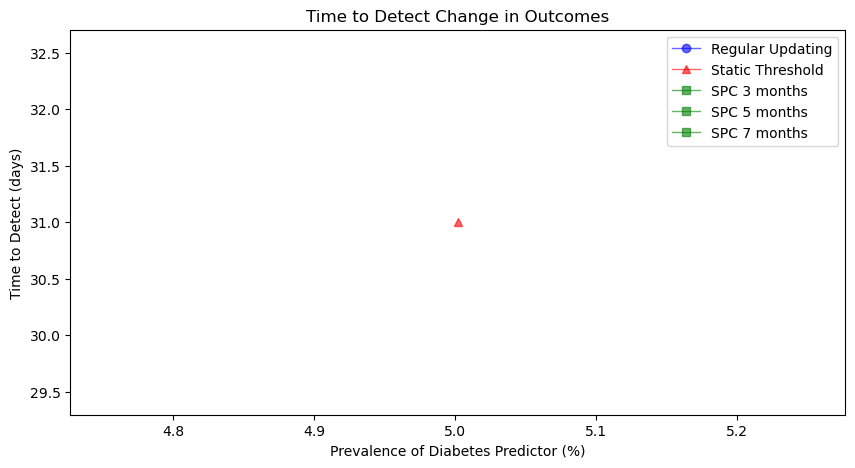

Total number of times each model was ran: 1
Number of times each model didn't detect change in outcomes: {'Static Threshold': 0, 'Regular Testing': 1, 'SPC3': 1, 'SPC5': 1, 'SPC7': 1, 'Bayesian': 0}
Percentage of times each model didn't detect change in outcomes: {'Static Threshold': 0.0, 'Regular Testing': 100.0, 'SPC3': 100.0, 'SPC5': 100.0, 'SPC7': 100.0, 'Bayesian': 0.0}


In [30]:
total_runs = 0

prev_increases = [1.0001]#, 1.0003, 1.0005, 1.0007, 1.0009, 1.0011, 1.0013, 1.0015, 1.0017, 1.0019, 1.0021, 1.0023, 1.0025, 1.0027, 1.0029]
undetected = dict({"Static Threshold": 0, "Regular Testing": 0, "SPC3": 0, "SPC5": 0, "SPC7": 0, "Bayesian": 0})

mean_TGFB = 13.23
std_TGFB = 5.18
mean_ADMA = 101.1
std_ADMA = 64.8
mean_BUN = 5.45
std_BUN = 1.11
mean_age = 63.27 
std_age = 10.09

TGFB_coef = 1.84
ADMA_coef = 1.137
DM_coef = 0.84
BUN_coef = 0.497
elderly_coef = 0.603

plt.figure(figsize=(10, 5))
plt.title(f"Time to Detect Change in Outcomes")

for startDateidx, startDateString in enumerate(startDateStrings):
    perc_dm = 0.05 # 5.5%
    dm_increases = []
    regular_ttd = []
    static_ttd = []
    spc_ttd3 = []
    spc_ttd5 = []
    spc_ttd7 = []
    bayesian_ttd = []
    for prev_increase in prev_increases:
        mydict = {
                'date': list(),
                'outcome': list(),
                'prediction': list(),
                'TGFB': list(),
                'ADMA':list(),
                'DM': list(),
                'BUN': list(),
                'elderly': list()
            }

        num_patients = 60

        # Define date range
        startDate = pd.to_datetime(startDateString, dayfirst=True)
        endDate = pd.to_datetime('31-12-2024', dayfirst=True)
        numdays = (endDate - startDate).days

        for i in range(numdays):
            curday = startDate + dt.timedelta(days=i)

            # increase the prevalence of diabetes over time
            if i % 30 == 0:
                perc_dm *= prev_increase # this increases the probability by x% each month

            TGFB = get_binom_from_normal(mean_TGFB, std_TGFB, num_patients, 1.011)
            ADMA = get_binom_from_normal(mean_ADMA, std_ADMA, num_patients, 0.019)
            DM = np.random.binomial(1, perc_dm, num_patients)
            BUN = get_binom_from_normal(mean_BUN, std_BUN, num_patients, 5.9)
            elderly = get_binom_from_normal(mean_age, std_age, num_patients, 60)

            # Calculate baseline log-odds
            # non_genetic_risk_score_model from paper
            lp = TGFB_coef * TGFB + ADMA_coef * ADMA + DM_coef * DM + BUN_coef * BUN + elderly_coef * elderly

            curpredictions = 1 / (1 + np.exp(-lp))  # Convert to probability
            curoutcomes = np.random.binomial(1, curpredictions)           
            

            # Append to dictionary from the distribution for each of the variables (Table 1)
            mydict['date'].extend([curday] * num_patients)
            mydict['outcome'].extend(curoutcomes)
            mydict['prediction'].extend(curpredictions)
            mydict['TGFB'].extend(TGFB)
            mydict['ADMA'].extend(ADMA)
            mydict['DM'].extend(DM)
            mydict['BUN'].extend(BUN)
            mydict['elderly'].extend(elderly)
            

        df = pd.DataFrame(mydict)

        # run EvaluatePrediction code to get the model metrics and when calibration drops (maybe switch time from this too)
        eval_model = EvaluatePredictions(colName='prediction')
        mytest = PREDICT(data=df, model=eval_model, startDate='min', endDate='max', timestep='week')
        mytest.addLogHook(CalibrationSlope(eval_model))
        mytest.run()
        log = mytest.getLog()
        #CalibrationSlopePlot(log)


        calibration_slope_values = list(log['CalibrationSlope'].values())
        # get the difference between the mean of the calibration slope values and the greatest deviation from 0 calibration slope value for the drop size
        largest_c_slope_change = max(abs(min(calibration_slope_values)), abs(max(calibration_slope_values)))
        drop_size = abs(statistics.mean(calibration_slope_values) - largest_c_slope_change)
        
        
        #drop_sizes.append(drop_size)
        dm_increases.append(perc_dm)
        # run regular testing
        ########################## Regular Testing ##########################
        model = RecalibratePredictions()
        model.trigger = TimeframeTrigger(model=model, updateTimestep=100, dataStart=df['date'].min(), dataEnd=df['date'].max())
        total_runs +=1
        ttd = get_model_updated_log(df, model, startDateStrings, startDateidx, "Regular Testing", undetected)
        regular_ttd.append(ttd)

        ############################ Static Threshold ############################
        model = RecalibratePredictions()
        recalthreshold = 0.851 # Paper has AUROC of 0.889, with lower CI at 0.851
        model.trigger = AUROCThreshold(model=model, prediction_threshold=recalthreshold)
        ttd = get_model_updated_log(df, model, startDateStrings, startDateidx, "Static Threshold", undetected)
        static_ttd.append(ttd)

        ############################ SPC ############################
        model = RecalibratePredictions()
        model.trigger = SPCTrigger(model=model, input_data=df, numMonths=3, verbose=False)
        ttd = get_model_updated_log(df, model, startDateStrings, startDateidx, "SPC3", undetected)
        spc_ttd3.append(ttd)

        model.trigger = SPCTrigger(model=model, input_data=df, numMonths=5, verbose=False)
        ttd = get_model_updated_log(df, model, startDateStrings, startDateidx, "SPC5", undetected)
        spc_ttd5.append(ttd)

        model.trigger = SPCTrigger(model=model, input_data=df, numMonths=7, verbose=False)
        ttd = get_model_updated_log(df, model, startDateStrings, startDateidx, "SPC7", undetected)
        spc_ttd7.append(ttd)

        ############################ Bayesian ############################
        # model = BayesianModel(input_data=df, priors={"Intercept": (0.01, 0.01), "TGFB": (mean_TGFB, std_TGFB), "ADMA": (mean_ADMA, std_ADMA), "DM": (DM_coef, 0.01), "BUN": (mean_BUN, std_BUN),
        #                                             "elderly": (elderly_coef, 0.01)}, cores=1, verbose=False, draws=100, chains=2)
        # model.trigger = BayesianRefitTrigger(model=model, input_data=df, refitFrequency=1)
        # ttd = get_model_updated_log(df, model, startDateStrings, startDateidx, "Bayesian", undetected)
        # bayesian_ttd.append(ttd)

            
    dm_increases = [x * 100 for x in dm_increases]  # Convert to percentage
    # plot the time to detect for all models

    regular_ttd_df = pd.DataFrame({"dm_increases": dm_increases, "regular_ttd": regular_ttd}).dropna(inplace=False)
    plt.plot("dm_increases", "regular_ttd", color='blue', label='Regular Updating', marker='o', alpha=0.6, linewidth=1, data=regular_ttd_df)
    static_ttd_df = pd.DataFrame({"dm_increases": dm_increases, "static_ttd": static_ttd}).dropna(inplace=False)
    plt.plot("dm_increases", "static_ttd", color='red', label='Static Threshold', marker='^', alpha=0.6, linewidth=1, data=static_ttd_df)
    spc_ttd3_df = pd.DataFrame({"dm_increases": dm_increases, "spc_ttd3": spc_ttd3}).dropna(inplace=False)
    plt.plot("dm_increases", "spc_ttd3", color='green', label='SPC 3 months', marker='s', alpha=0.6, linewidth=1, data=spc_ttd3_df)
    spc_ttd5_df = pd.DataFrame({"dm_increases": dm_increases, "spc_ttd5": spc_ttd5}).dropna(inplace=False)
    plt.plot("dm_increases", "spc_ttd5", color='green', label='SPC 5 months', marker='s', alpha=0.6, linewidth=1, data=spc_ttd5_df)
    spc_ttd7_df = pd.DataFrame({"dm_increases": dm_increases, "spc_ttd7": spc_ttd7}).dropna(inplace=False)
    plt.plot("dm_increases", "spc_ttd7", color='green', label='SPC 7 months', marker='s', alpha=0.6, linewidth=1, data=spc_ttd7_df)
    # bayesian_ttd_df = pd.DataFrame({"dm_increases": dm_increases, "bayesian_ttd": bayesian_ttd}).dropna(inplace=False)
    # plt.plot("dm_increases", "bayesian_ttd", color='purple', label='Bayesian', marker='x', alpha=0.6, linewidth=1, data=bayesian_ttd_df)
plt.xlabel("Prevalence of Diabetes Predictor (%)")
plt.ylabel("Time to Detect (days)")
handles, labels = plt.gca().get_legend_handles_labels()
# Ensure only the first plot of each model is labelled in the legend
plt.legend(handles[:6], labels[:6])
plt.show()


# Print the number of undetected models
print(f"Total number of times each model was ran: {total_runs}")
percentages = {key: (value / total_runs * 100) if total_runs > 0 else 0 for key, value in undetected.items()}
print("Number of times each model didn't detect change in outcomes:", undetected)
print("Percentage of times each model didn't detect change in outcomes:", percentages)


#### Multivariate 'realistic model' - QRISK2

Diabetes increasing whilst smoking is decreasing.

[QRISK2 Paper](https://www.bmj.com/content/bmj/336/7659/1475.full.pdf)

Using the data on Women from the derivation cohort from the paper. 

BMI mean $\pm$ std was taken from: https://bmcpublichealth.biomedcentral.com/articles/10.1186/s12889-021-10606-1

Townsend mean $\pm$ std was estimated by using the quintile ranges from https://www.qresearch.org/media/1056/cut-offs-for-townsend-quintiles-in-england-and-wales-and-qresearch.pdf:

$\text{Mean} \approx \frac{(-4.81) + (-2.40) + (-0.55) + (2.12) + (7.19)}{5}$

Using the midpoints:
- Quintile 1: ( $\frac{-6.61 + (-3.20)}{2} = -4.81$ )
- Quintile 2: ( $\frac{-3.19 + (-1.60)}{2} = -2.40$ )
- Quintile 3: ( $\frac{-1.59 + 0.50}{2} = -0.55$ )
- Quintile 4: ( $\frac{0.51 + 3.30}{2} = 2.12$ )
- Quintile 5: ( $\frac{3.31 + 11.06}{2} = 7.19$ )

$\text{Mean} \approx \frac{-4.81 + (-2.40) + (-0.55) + (2.12) + (7.19)}{5} = 0.31$

Estimating the Standard Deviation

$\text{Standard Deviation} \approx \frac{\text{Range}}{4}$

Where: $ \text{Range} = 11.06 - (-6.61) = 17.67 $

$ \text{Standard Deviation} \approx \frac{17.67}{4} = 4.42 $

BMI mean and std from: https://elifesciences.org/articles/71862

Cholesterol/HDL ratio using data from 2008 (https://www.who.int/data/gho/data/indicators/indicator-details/GHO/gho-mean-hdl-cholesterol-crude) Cholesterol average as 5.3 +- 0.1  HDL Cholesterol as 1.45 +- 0.05, getting a Cholesterol/HDL ratio of 3.66 +- 0.144


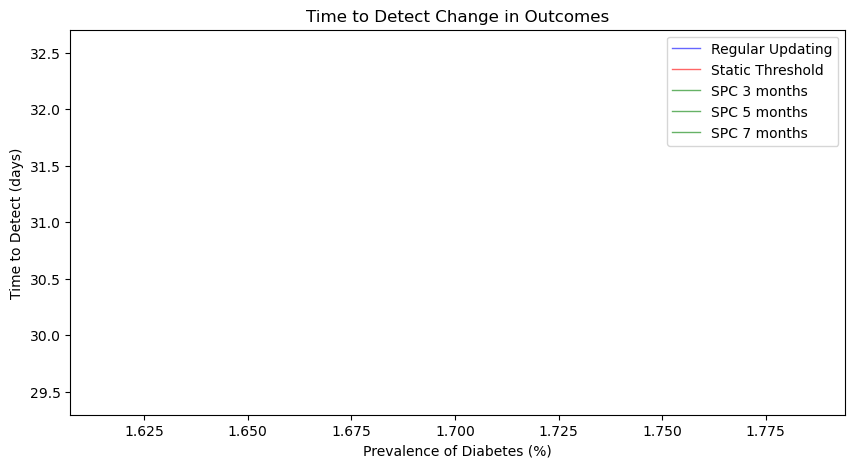

Total number of times each model was ran: 1
Number of times each model didn't detect change in outcomes: {'Static Threshold': 0, 'Regular Testing': 1, 'SPC3': 1, 'SPC5': 1, 'SPC7': 1, 'Bayesian': 0}
Percentage of times each model didn't detect change in outcomes: {'Static Threshold': 0.0, 'Regular Testing': 100.0, 'SPC3': 100.0, 'SPC5': 100.0, 'SPC7': 100.0, 'Bayesian': 0.0}


In [31]:
plt.figure(figsize=(10, 5))
plt.title(f"Time to Detect Change in Outcomes")

# Define the coefficients (hazard ratios converted to log-odds)
coefs = {"White": np.log(1), 
    "Indian": np.log(1.43),
    "Pakistani": np.log(1.8),
    "Bangladeshi": np.log(1.35),
    "Other_Asian": np.log(1.15),
    "Black_Caribbean": np.log(1.08),
    "Black_African": np.log(0.58),
    "Chinese": np.log(0.69),
    "Other": np.log(1.04),
    "Age": np.log(1.66),
    "BMI": np.log(1.08),
    "Townsend": np.log(1.37),
    "SBP": np.log(1.2),
    "CholHDL_ratio": np.log(1.17),
    "Family_CHD": np.log(1.99),
    "Current_smoker": np.log(1.8),
    "Treated_HTN": np.log(1.54),
    "DM": np.log(2.54),
    "RA": np.log(1.5),
    "AF": np.log(3.06),
    "Renal_disease": np.log(1.7),
    "Age_BMI": np.log(0.976),
    "Age_Townsend": np.log(0.938),
    "Age_SBP": np.log(0.966),
    "Age_Family_CHD": np.log(0.927),
    "Age_Smoking": np.log(0.931),
    "Age_Treated_HTN": np.log(0.952),
    "Age_DM": np.log(0.904),
    "Age_AF": np.log(0.858)
}


# Percentage variables (/100)
percent_family_history_chd = 0.126
percent_treated_hypertension = 0.0712
percent_rheumatoid_arthritis = 0.0093
percent_atrial_fibrillation = 0.0035
percent_renal_disease = 0.0016

# Age variable
median_age = 49
IQR_age = 19
mean_age = median_age
std_age = IQR_age / 1.35

# Mean and standard deviation variables
mean_bmi = 33.8
std_bmi = 6.1

mean_townsend = 17.67
std_townsend = 4.42

mean_sbp = 26.6
std_sbp = 4.4

mean_chol_hdl_ratio = 3.66
std_chol_hdl_ratio = 0.144


intercept = None
baseline_prob = 0.233 # 23.3%
total_runs = 0

prev_increases = [1.0001]#, 1.0003, 1.0005, 1.0007, 1.0009, 1.0011, 1.0013, 1.0015, 1.0017, 1.0019, 1.0021, 1.0023, 1.0025, 1.0027, 1.0029]
smoking_decrease = [0.9995]#, 0.9993, 0.9991, 0.9989, 0.9987, 0.9985, 0.9983, 0.9981, 0.9979, 0.9977, 0.9975, 0.9973, 0.9971, 0.9969, 0.9967] # e.g. reduce by 0.05%
undetected = dict({"Static Threshold": 0, "Regular Testing": 0, "SPC3": 0, "SPC5": 0, "SPC7": 0, "Bayesian": 0})

for startDateidx, startDateString in enumerate(startDateStrings):
    percent_type_2_diabetes = 0.017 # reset these for each start date
    percent_current_smoker = 0.228
    dm_increases = []
    regular_ttd = []
    static_ttd = []
    spc_ttd3 = []
    spc_ttd5 = []
    spc_ttd7 = []
    bayesian_ttd = []
    for num, prev_increase in enumerate(prev_increases):
        mydict = {
                'date': list(),
                'outcome': list(),
                'prediction': list(),
                'White': list(),
                'Indian': list(),
                'Pakistani': list(),
                'Bangladeshi': list(),
                'Other_Asian': list(),
                'Black_Caribbean': list(),
                'Black_African': list(),
                'Chinese': list(),
                'Other': list(),
                'Age': list(),
                'BMI':list(),
                'Townsend': list(),
                'SBP': list(),
                'CholHDL_ratio': list(),
                'Family_CHD': list(),
                'Current_smoker': list(),
                'Treated_HTN': list(),
                'DM': list(),
                'RA': list(),
                'AF': list(),
                'Renal_disease': list()
            }

        num_patients = 60

        # Define date range
        startDate = pd.to_datetime(startDateString, dayfirst=True)
        endDate = pd.to_datetime('31-12-2024', dayfirst=True)
        numdays = (endDate - startDate).days

        
        for i in range(numdays):
            curday = startDate + dt.timedelta(days=i)

            # increase the prevalence of diabetes over time
            if i % 30 == 0:
                percent_type_2_diabetes *= prev_increase # this increases the probability by x% each month
                percent_current_smoker *= smoking_decrease[num] # decrease the prevalence of smoking over time
            if percent_type_2_diabetes < 0 or percent_type_2_diabetes > 1:
                print("Percentage of people with DM", percent_type_2_diabetes)
            if percent_current_smoker < 0 or percent_current_smoker > 1:
                print("Percentage of people who are current smokers", percent_current_smoker)


            pat_factors = {"Age": np.random.normal(mean_age, std_age, num_patients),
                "BMI": np.random.normal(mean_bmi, std_bmi, num_patients),
                "Townsend": np.random.normal(mean_townsend, std_townsend, num_patients),
                "SBP": np.random.normal(mean_sbp, std_sbp, num_patients),
                "CholHDL_ratio": np.random.normal(mean_chol_hdl_ratio, std_chol_hdl_ratio, num_patients),
                "Family_CHD": np.random.binomial(1, percent_family_history_chd, num_patients),
                "Current_smoker": np.random.binomial(1, percent_current_smoker, num_patients),
                "Treated_HTN": np.random.binomial(1, percent_treated_hypertension, num_patients),
                "DM": np.random.binomial(1, percent_type_2_diabetes, num_patients),
                "RA": np.random.binomial(1, percent_rheumatoid_arthritis, num_patients),
                "AF": np.random.binomial(1, percent_atrial_fibrillation, num_patients),
                "Renal_disease": np.random.binomial(1, percent_renal_disease, num_patients)
            }

            ethnicity_assignment = select_ethnic_group(num_patients)
            pat_factors.update(ethnicity_assignment) # combine ethnicity dict with ethnic


            # Calculate baseline log-odds
            weighted_coef_sum = coefs['White']*pat_factors['White'] + coefs['Indian']*pat_factors['Indian'] + coefs['Pakistani']*pat_factors['Pakistani'] + coefs['Bangladeshi']*pat_factors['Bangladeshi'] 
            weighted_coef_sum += coefs['Other_Asian']*pat_factors['Other_Asian'] + coefs['Black_Caribbean']*pat_factors['Black_Caribbean'] + coefs['Black_African']*pat_factors['Black_African'] 
            weighted_coef_sum += coefs['Chinese']*pat_factors['Chinese'] + coefs['Other']*pat_factors['Other'] + coefs['Age']*(pat_factors['Age']) + coefs['BMI']*(pat_factors['BMI']) 
            weighted_coef_sum += coefs['Townsend']*(pat_factors['Townsend']) + coefs['SBP']*(pat_factors['SBP']) + coefs['CholHDL_ratio']*(pat_factors['CholHDL_ratio']) 
            weighted_coef_sum += coefs["Family_CHD"]*(pat_factors["Family_CHD"]) + coefs["Current_smoker"]*(pat_factors["Current_smoker"]) 
            weighted_coef_sum += coefs["Treated_HTN"]*(pat_factors["Treated_HTN"]) + coefs["DM"]*(pat_factors["DM"]) + coefs["RA"]*(pat_factors["RA"]) 
            weighted_coef_sum += coefs["AF"]*(pat_factors["AF"]) + coefs["Renal_disease"]*(pat_factors["Renal_disease"]) + (coefs["Age_BMI"] * pat_factors["Age"] * pat_factors["BMI"]) 
            weighted_coef_sum += (coefs["Age_Townsend"] * pat_factors["Age"] * pat_factors["Townsend"]) + (coefs["Age_SBP"] * pat_factors["Age"] * pat_factors["SBP"]) 
            weighted_coef_sum += (coefs["Age_Family_CHD"] * pat_factors["Age"] * pat_factors["Family_CHD"]) + (coefs["Age_Smoking"] * pat_factors["Age"] * pat_factors["Current_smoker"]) 
            weighted_coef_sum += (coefs["Age_Treated_HTN"] * pat_factors["Age"] * pat_factors["Treated_HTN"]) + (coefs["Age_DM"] * pat_factors["Age"] * pat_factors["DM"])
            weighted_coef_sum += (coefs["Age_AF"] * pat_factors["Age"] * pat_factors["AF"])

        
            intercept = np.log(baseline_prob / (1 - baseline_prob)) - weighted_coef_sum

            # Compute log-odds
            lp = intercept + weighted_coef_sum

            curpredictions = 1 / (1 + np.exp(-lp))  # Convert to probability
            curoutcomes = np.random.binomial(1, curpredictions)           
            

            # Append to dictionary from the distribution for each of the variables (Table 1)
            mydict['date'].extend([curday] * num_patients)
            mydict['outcome'].extend(curoutcomes)
            mydict['prediction'].extend(curpredictions)
            mydict['White'].extend(pat_factors['White'])
            mydict['Indian'].extend(pat_factors['Indian'])
            mydict['Pakistani'].extend(pat_factors['Pakistani'])
            mydict['Bangladeshi'].extend(pat_factors['Bangladeshi'])
            mydict['Other_Asian'].extend(pat_factors['Other_Asian'])
            mydict['Black_Caribbean'].extend(pat_factors['Black_Caribbean'])
            mydict['Black_African'].extend(pat_factors['Black_African'])
            mydict['Chinese'].extend(pat_factors['Chinese'])
            mydict['Other'].extend(pat_factors['Other'])
            mydict['Age'].extend(pat_factors['Age'])
            mydict['BMI'].extend(pat_factors['BMI'])
            mydict['Townsend'].extend(pat_factors['Townsend'])
            mydict['SBP'].extend(pat_factors['SBP'])
            mydict['CholHDL_ratio'].extend(pat_factors['CholHDL_ratio'])
            mydict['Family_CHD'].extend(pat_factors['Family_CHD'])
            mydict['Current_smoker'].extend(pat_factors['Current_smoker'])
            mydict['Treated_HTN'].extend(pat_factors['Treated_HTN'])
            mydict['DM'].extend(pat_factors['DM'])
            mydict['RA'].extend(pat_factors['RA'])
            mydict['AF'].extend(pat_factors['AF'])
            mydict['Renal_disease'].extend(pat_factors['Renal_disease'])

            

        df = pd.DataFrame(mydict)


        # run EvaluatePrediction code to get the model metrics and when calibration drops (maybe switch time from this too)
        eval_model = EvaluatePredictions(colName='prediction')
        mytest = PREDICT(data=df, model=eval_model, startDate='min', endDate='max', timestep='week')
        mytest.addLogHook(CalibrationSlope(eval_model))
        mytest.run()
        log = mytest.getLog()
        #CalibrationSlopePlot(log)


        calibration_slope_values = list(log['CalibrationSlope'].values())
        # get the difference between the mean of the calibration slope values and the greatest deviation from 0 calibration slope value for the drop size
        largest_c_slope_change = max(abs(min(calibration_slope_values)), abs(max(calibration_slope_values)))
        drop_size = abs(statistics.mean(calibration_slope_values) - largest_c_slope_change)


        #drop_sizes.append(drop_size)
        dm_increases.append(percent_type_2_diabetes)
        # run regular testing
        ########################## Regular Testing ##########################
        model = RecalibratePredictions()
        model.trigger = TimeframeTrigger(model=model, updateTimestep=100, dataStart=df['date'].min(), dataEnd=df['date'].max())
        total_runs +=1
        ttd = get_model_updated_log(df, model, startDateStrings, startDateidx, "Regular Testing", undetected)
        regular_ttd.append(ttd)

        ############################ Static Threshold ############################
        model = RecalibratePredictions()
        recalthreshold = 0.811 # Paper has AUROC of 0.814, with lower CI at 0.811 
        model.trigger = AUROCThreshold(model=model, prediction_threshold=recalthreshold)
        ttd = get_model_updated_log(df, model, startDateStrings, startDateidx, "Static Threshold", undetected)
        static_ttd.append(ttd)

        ############################ SPC ############################
        model = RecalibratePredictions()
        model.trigger = SPCTrigger(model=model, input_data=df, numMonths=3, verbose=False)
        ttd = get_model_updated_log(df, model, startDateStrings, startDateidx, "SPC3", undetected)
        spc_ttd3.append(ttd)

        model.trigger = SPCTrigger(model=model, input_data=df, numMonths=5, verbose=False)
        ttd = get_model_updated_log(df, model, startDateStrings, startDateidx, "SPC5", undetected)
        spc_ttd5.append(ttd)

        model.trigger = SPCTrigger(model=model, input_data=df, numMonths=7, verbose=False)
        ttd = get_model_updated_log(df, model, startDateStrings, startDateidx, "SPC7", undetected)
        spc_ttd7.append(ttd)

        ############################ Bayesian ############################
        # model = BayesianModel(input_data=df, priors={"Intercept": (intercept.mean(), intercept.std()), 
        #                                             "White": (1,0.01), 
        #                                             "Indian": (1.43,0.01),
        #                                             "Pakistani": (1.8,0.01),
        #                                             "Bangladeshi": (1.35,0.01),
        #                                             "Other_Asian": (1.15,0.01),
        #                                             "Black_Caribbean": (1.08,0.01),
        #                                             "Black_African": (0.58,0.01),
        #                                             "Chinese": (0.69,0.01),
        #                                             "Other": (1.04,0.01),
        #                                             "Age": (mean_age, std_age),
        #                                             "BMI": (mean_bmi, std_bmi),
        #                                             "Townsend": (mean_townsend, std_townsend),
        #                                             "SBP": (mean_sbp, std_sbp),
        #                                             "CholHDL_ratio": (mean_chol_hdl_ratio, std_chol_hdl_ratio),
        #                                             "Family_CHD": (coefs['Family_CHD'], 0.01),
        #                                             "Current_smoker": (coefs['Current_smoker'], 0.01),
        #                                             "Treated_HTN": (coefs['Treated_HTN'], 0.01),
        #                                             "DM": (coefs['DM'], 0.01),
        #                                             "RA": (coefs['RA'], 0.01),
        #                                             "AF": (coefs['AF'], 0.01),
        #                                             "Renal_disease": (coefs['Renal_disease'], 0.01)}, 
        #                                             cores=1, verbose=False, draws=100, chains=2, 
        #                                             model_formula="outcome ~ White + Indian + Pakistani + Bangladeshi + Other_Asian + Black_Caribbean + Black_African + Chinese + Other + Age + BMI + Townsend + SBP + CholHDL_ratio + Family_CHD + Current_smoker + Treated_HTN + DM + RA + AF + Renal_disease + Age*BMI + Age*Townsend + Age*SBP + Age*Family_CHD + Age*Current_smoker + Age*Treated_HTN + Age*DM + Age*AF")
        # model.trigger = BayesianRefitTrigger(model=model, input_data=df, refitFrequency=1)
        # print("Running Bayesian model")
        # ttd = get_model_updated_log(df, model, startDateStrings, startDateidx, "Bayesian", undetected)
        # bayesian_ttd.append(ttd)

            
    dm_increases = [x * 100 for x in dm_increases]  # Convert to percentage
    # plot the time to detect for all models

    regular_ttd_df = pd.DataFrame({"dm_increases": dm_increases, "regular_ttd": regular_ttd}).dropna(inplace=False)
    plt.plot("dm_increases", "regular_ttd", color='blue', label='Regular Updating', alpha=0.6, linewidth=1, data=regular_ttd_df)
    static_ttd_df = pd.DataFrame({"dm_increases": dm_increases, "static_ttd": static_ttd}).dropna(inplace=False)
    plt.plot("dm_increases", "static_ttd", color='red', label='Static Threshold', alpha=0.6, linewidth=1, data=static_ttd_df)
    
    spc_ttd3_df = pd.DataFrame({"dm_increases": dm_increases, "spc_ttd3": spc_ttd3}).dropna(inplace=False)
    plt.plot("dm_increases", "spc_ttd3", color='green', label='SPC 3 months', alpha=0.6, linewidth=1, data=spc_ttd3_df)
    spc_ttd5_df = pd.DataFrame({"dm_increases": dm_increases, "spc_ttd5": spc_ttd5}).dropna(inplace=False)
    plt.plot("dm_increases", "spc_ttd5", color='green', label='SPC 5 months', alpha=0.6, linewidth=1, data=spc_ttd5_df)
    spc_ttd7_df = pd.DataFrame({"dm_increases": dm_increases, "spc_ttd7": spc_ttd7}).dropna(inplace=False)
    plt.plot("dm_increases", "spc_ttd7", color='green', label='SPC 7 months', alpha=0.6, linewidth=1, data=spc_ttd7_df)
    # bayesian_ttd_df = pd.DataFrame({"dm_increases": dm_increases, "bayesian_ttd": bayesian_ttd}).dropna(inplace=False)
    # plt.plot("dm_increases", "bayesian_ttd", color='purple', label='Bayesian', alpha=0.6, linewidth=1, data=bayesian_ttd_df)

plt.xlabel("Prevalence of Diabetes (%)")
plt.ylabel("Time to Detect (days)")
handles, labels = plt.gca().get_legend_handles_labels()
# Ensure only the first plot of each model is labelled in the legend
plt.legend(handles[:6], labels[:6])
plt.show()


# Print the number of undetected models
print(f"Total number of times each model was ran: {total_runs}")
percentages = {key: (value / total_runs * 100) if total_runs > 0 else 0 for key, value in undetected.items()}
print("Number of times each model didn't detect change in outcomes:", undetected)
print("Percentage of times each model didn't detect change in outcomes:", percentages)

